<a href="https://colab.research.google.com/github/yeb2Binfang/2021CS-GY9223/blob/main/Lab/Lab3/Lab3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recall the cyclical learning rate policy discussed in the class. The learning rate changes in a cyclical manner between lrmin and lrmax, which are hyperparameters that need to be specified. For this problem, you first need to read carefully the article referenced below as you will be making use of the code there (in Keras) and modifying it as needed. For those who want to work in Pytorch, there are open source implementations of this policy available which you can easily search for and build over them. You will work with the FashionMNIST dataset and MiniGoogLeNet (described in reference).

1. Fix batch size to 64 and start with 10 candidate learning rates between $10^{−9}$ and $10^1$ and train your model for 5 epochs. Plot the training loss as a function of the learning rate. You should see a curve like Figure 3 in the reference below. From that figure identify the values of $lr_{min}$ and $lr_{max}$. (2)
2. Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and $lr_{min}$ and $lr_{max}$ values obtained in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference). (3)
3. We want to test if increasing batch size for a fixed learning rate has the same effect as decreasing learning rate for fixed batch size. Fix learning rate to $lr_{max}$ and train your network starting with batch size 32 and incrementally going up to 16384 (in increments of a factor of 2; like 32, 64...). You can choose a step size (in terms of the number of iterations) to increment the batch size. If your GPU cannot handle large batch sizes, you need to employ an effective batch size approach as discussed in Lecture 3 to simulate large batches. Plot the training loss. Is the generalization of your final model similar or different from than cyclical learning rate policy? (10)

*reference:*

* Leslie N. Smith Cyclical Learning Rates for Training Neural Networks. Available at https://arxiv.org/abs/1506.01186.
* Keras implementation of cyclical learning rate policy. Available at https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/

In [1]:
!wget https://raw.githubusercontent.com/yeb2Binfang/ECE-GY9143HPML/main/Lab/Lab3/clr_callback.py
!wget https://raw.githubusercontent.com/yeb2Binfang/ECE-GY9143HPML/main/Lab/Lab3/config.py
!wget https://raw.githubusercontent.com/yeb2Binfang/ECE-GY9143HPML/main/Lab/Lab3/learningratefinder.py
!wget https://raw.githubusercontent.com/yeb2Binfang/ECE-GY9143HPML/main/Lab/Lab3/minigooglenet.py

--2022-03-23 19:37:56--  https://raw.githubusercontent.com/yeb2Binfang/ECE-GY9143HPML/main/Lab/Lab3/clr_callback.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4531 (4.4K) [text/plain]
Saving to: ‘clr_callback.py’

clr_callback.py     100%[===================>]   4.42K  --.-KB/s    in 0s      

2022-03-23 19:37:56 (27.8 MB/s) - ‘clr_callback.py’ saved [4531/4531]

--2022-03-23 19:37:56--  https://raw.githubusercontent.com/yeb2Binfang/ECE-GY9143HPML/main/Lab/Lab3/config.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729 [te

In [2]:
%run clr_callback.py
%run learningratefinder.py
%run minigooglenet.py
%run config.py

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10960137122510355104
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14346392346584322483
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

In [6]:
import sys
sys.argv=['']
del sys

ap = argparse.ArgumentParser()
ap.add_argument("-f", "--lr-find", type=int, default=0,
	help="whether or not to find optimal learning rate")
args = vars(ap.parse_args())

In [7]:
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading Fashion MNIST data...
4431872/4422102 [==============================] - 0s 0us/step


## Problem 1
Fix batch size to 64 and start with 10 candidate learning rates between $10^{−9}$ and $10^1$ and train your model for 5 epochs. Plot the training loss as a function of the learning rate. You should see a curve like Figure 3 in the reference below. From that figure identify the values of $lr_{min}$ and $lr_{max}$. (2)

In [8]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=1e-10,
	max_lr=10,
	step_size=10)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=5,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


[INFO] training network...
Epoch 1/5
937/937 [==============================] - 114s 109ms/step - loss: 2.9927 - accuracy: 0.1005 - val_loss: 2.6956 - val_accuracy: 0.1000
Epoch 2/5
937/937 [==============================] - 100s 106ms/step - loss: 2.7266 - accuracy: 0.1003 - val_loss: 2.6691 - val_accuracy: 0.1000
Epoch 3/5
937/937 [==============================] - 104s 111ms/step - loss: 2.7906 - accuracy: 0.0995 - val_loss: 2.6049 - val_accuracy: 0.1000
Epoch 4/5
937/937 [==============================] - 105s 112ms/step - loss: 2.6812 - accuracy: 0.0995 - val_loss: 2.5209 - val_accuracy: 0.1000
Epoch 5/5
937/937 [==============================] - 100s 106ms/step - loss: 2.7864 - accuracy: 0.0997 - val_loss: 2.5354 - val_accuracy: 0.1000
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.00      0.00      0.00      1000
     trouser       0.00      0.00      0.00      1000
    pullover       0.00      0.00      0.00      1000
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/3
938/938 [==============================] - 94s 100ms/step - loss: 8.3722 - accuracy: 0.1003
Epoch 2/3
938/938 [==============================] - 94s 100ms/step - loss: 8.2824 - accuracy: 0.1000
Epoch 3/3
938/938 [==============================] - 94s 101ms/step - loss: 3.1149 - accuracy: 0.1007


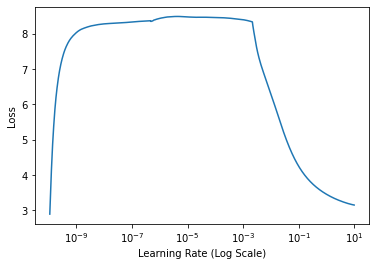

In [9]:
lrf = LearningRateFinder(model)
lrf.find(
		aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((len(trainX) / float(BATCH_SIZE))),
		batchSize=BATCH_SIZE)

	# plot the loss for the various learning rates and save the
	# resulting plot to disk
lrf.plot_loss()

## Problem 2
Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and $lr_{min}$ and $lr_{max}$ values obtained in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference). (3)

In [ ]:
MIN_LR = 1e-3
MAX_LR = 10

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=STEP_SIZE)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=5,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, 5)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")

## Problem 3
We want to test if increasing batch size for a fixed learning rate has the same effect as decreasing learning rate for fixed batch size. Fix learning rate to $lr_{max}$ and train your network starting with batch size 32 and incrementally going up to 16384 (in increments of a factor of 2; like 32, 64...). You can choose a step size (in terms of the number of iterations) to increment the batch size. If your GPU cannot handle large batch sizes, you need to employ an effective batch size approach as discussed in Lecture 3 to simulate large batches. Plot the training loss. Is the generalization of your final model similar or different from than cyclical learning rate policy? (10)